# ROC curves with confidence intervals

This notebook shows how to plot ROC curves with confidence bands.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import score_analysis
from score_analysis import Scores

In [3]:
sns.set_style("dark")

## Basic ROC curve

We start by generating some synthetic data and plotting it's ROC curve.

In [4]:
pos = np.random.normal(loc=5.0, scale=1.0, size=10_000)
neg = np.random.normal(loc=1.0, scale=1.0, size=10_000)

scores = Scores(pos, neg)

In [5]:
threshold, eer = scores.eer()
ci = scores.bootstrap_ci("eer")
print(f"Threshold: {threshold:.4f}. 95%-CI: ({ci[0, 0]:.4f}, {ci[0, 1]:.4f})")
print(f"EER: {eer:.3%}. 95%-CI: ({ci[1, 0]:.3%}, {ci[1, 1]:.3%})")

Threshold: 3.0018. 95%-CI: (2.9480, 3.0275)
EER: 2.108%. 95%-CI: (1.886%, 2.308%)


In [6]:
fnr_init = np.logspace(-4, -1, 200)
threshold = scores.threshold_at_fnr(fnr_init)
fpr = scores.fpr(threshold)
fnr = scores.fnr(threshold)

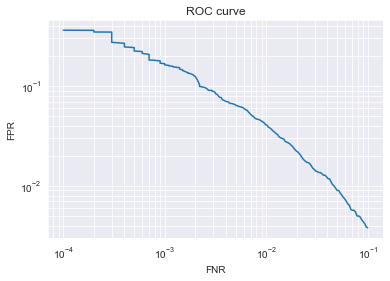

In [7]:
plt.figure()
plt.plot(fnr, fpr)
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both")
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("ROC curve")
plt.show()

## ROC curve with confidence intervals

In [8]:
def fpr_at_fnr(scores: Scores, fnr: np.ndarray) -> np.ndarray:
    """
    Calculates FPR at given FNR. 
    
    Used to vectorize bootstrapping.
    """
    threshold = scores.threshold_at_fnr(fnr)
    fpr = scores.fpr(threshold)
    return fpr

### Method A: Regular bootstrap via replacement sampling

In [9]:
fnr = np.logspace(-4, -1, 200)

fpr, fnr, lower, upper = score_analysis.tools.roc_with_ci(
    scores, fnr=fnr, method="bootstrap", alpha=0.05
)

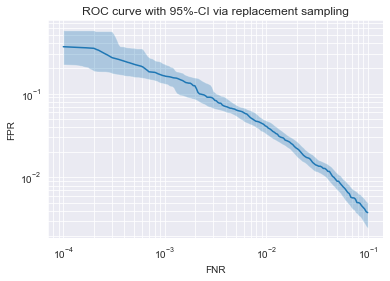

In [10]:
plt.figure()
plt.plot(fnr, fpr)
plt.fill_between(fnr, lower, upper, alpha=.3)
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both")
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("ROC curve with 95%-CI via replacement sampling")
plt.show()

### Method B: Bootstrap sampling with a custom sampling method

We can override the standard sampling method with a custom one, that adds uncertainty in the scores by adding Gaussian noise to the sampled scores.

In [11]:
def sample(scores: Scores, sigma: float) -> Scores:
    # We don't fix the ratio of positive and negative scores.
    n = scores.pos.size + scores.neg.size
    p = scores.pos.size / n
    nb_pos = np.random.binomial(n, p)
    
    # Then we sample scores
    pos = np.random.choice(scores.pos, size=nb_pos, replace=True)
    neg = np.random.choice(scores.neg, size=n - nb_pos, replace=True)
    
    # And finally we add noise
    pos = pos + np.random.normal(size=pos.size, scale=sigma)
    neg = neg + np.random.normal(size=neg.size, scale=sigma)
    
    scores = Scores(
        pos, neg, score_class=scores.score_class, equal_class=scores.equal_class
    )
    return scores

In [12]:
fnr = np.logspace(-4, -1, 200)

# The measured FPR values
fpr = fpr_at_fnr(scores, fnr)

# The confidence interval
fpr_ci = scores.bootstrap_ci(
    metric=partial(fpr_at_fnr, fnr=fnr),
    nb_samples=1000,
    method=partial(sample, sigma=0.1),
)
lower, upper = fpr_ci[:, 0], fpr_ci[:, 1]

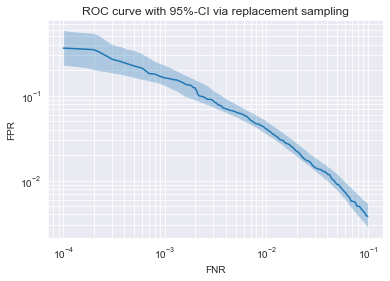

In [13]:
plt.figure()
plt.plot(fnr, fpr)
plt.fill_between(fnr, lower, upper, alpha=.3)
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both")
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("ROC curve with 95%-CI via replacement sampling")
plt.show()

### Method C: Binomial CI on FPR at fixed thresholds

In [14]:
fnr = np.logspace(-4, -1, 200)

fpr, fnr, lower, upper = score_analysis.tools.roc_with_ci(
    scores, fnr=fnr, method="binomial", alpha=0.05
)

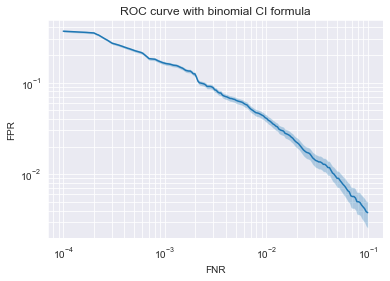

In [15]:
plt.figure()
plt.plot(fnr, fpr)
plt.fill_between(fnr, lower, upper, alpha=.3)
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both")
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("ROC curve with binomial CI formula")
plt.show()

This method shows almost no uncertainty in the low FNR range. This makes sense, because this method does not take into account the uncertainty of computing the threshold at a given FNR value. In contrast, method A, looks at the uncertainty of the full mapping FNR -> threshold -> FPR.

It should be noted that this method is much, much faster, since it is fully vectorized.

### Method D: The pessimist (deprecated)

We take the union of the confidence intervals generated by methods A (regular bootstrap) and C (binomial).

In [16]:
fnr = np.logspace(-4, -1, 200)

fpr, fnr, lower, upper = score_analysis.tools.roc_with_ci(
    scores, fnr=fnr, method="pessimist", alpha=0.05
)

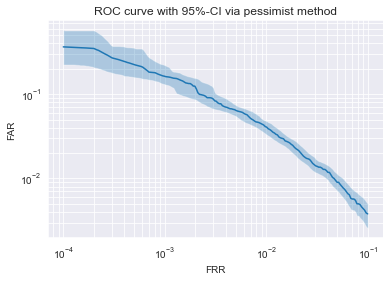

In [17]:
plt.figure()
plt.plot(fnr, fpr)
plt.fill_between(fnr, lower, upper, alpha=.3)
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both")
plt.xlabel("FRR")
plt.ylabel("FAR")
plt.title("ROC curve with 95%-CI via pessimist method")
plt.show()

### Method D: Bootstrapping using proportional sampling of 80% of data

This method is included only for illustrative purposes. Considering how small the confidence intervals are, I wouldn't recommend using it.

In [18]:
fnr = np.logspace(-4, -1, 200)

fpr = fpr_at_fnr(scores, fnr)
fpr_ci = scores.bootstrap_ci(
    metric=partial(fpr_at_fnr, fnr=fnr),
    nb_samples=1000,
    method="proportion",
    ratio=0.8,
)
lower, upper = fpr_ci[:, 0], fpr_ci[:, 1]

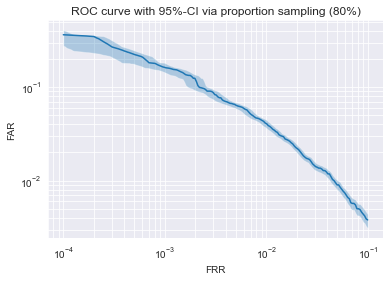

In [19]:
plt.figure()
plt.plot(fnr, fpr)
plt.fill_between(fnr, lower, upper, alpha=.3)
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both")
plt.xlabel("FRR")
plt.ylabel("FAR")
plt.title("ROC curve with 95%-CI via proportion sampling (80%)")
plt.show()